In [285]:
import numpy as np
import matplotlib.pyplot as plt
# train test split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [286]:
def f(x, a, b, noise=0.0):
    fout = np.sin(5*a*x) * np.exp(-x**2) + b * np.cos(x)
    if noise > 0:
        fout += np.random.normal(0, noise, size=fout.shape)
    return fout

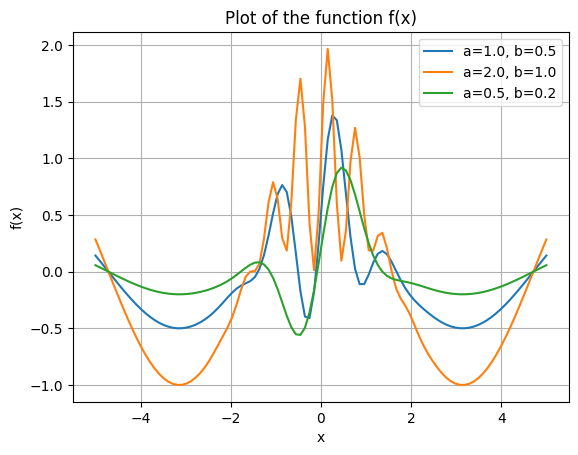

In [287]:
# plot the function
a = 1.0
b = 0.5
xrange = np.linspace(-5, 5, 100)
plt.plot(xrange, f(xrange, 1.0, 0.5), label="a=1.0, b=0.5")
plt.plot(xrange, f(xrange, 2.0, 1.0), label="a=2.0, b=1.0")
plt.plot(xrange, f(xrange, 0.5, 0.2), label="a=0.5, b=0.2")
plt.title('Plot of the function f(x)')
plt.xlabel('x') 
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.show()

In [288]:
# generate data for training a model
# set b = 0.5
# for random a s in [0.1, 2.0], we generate 100 points

n_generate = 10_000
noise = 0.2
x_range = np.linspace(-5, 5, 100)
a_values = np.random.uniform(0.1, 3.0, n_generate)
y_values = f(x_range[:, None], a_values, 0.5, noise).transpose()

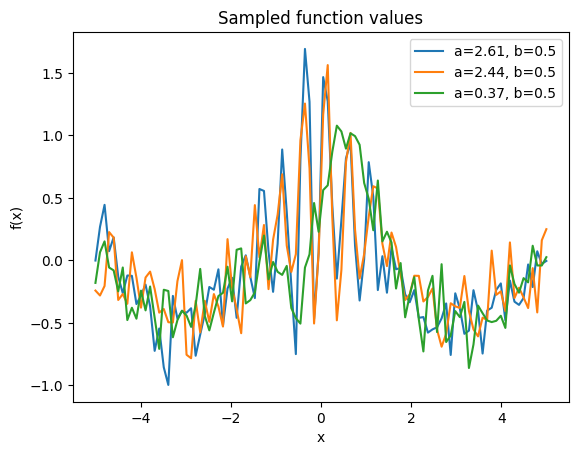

In [289]:
plt.plot(x_range, y_values[0], label=f"a={a_values[0]:.2f}, b=0.5")
plt.plot(x_range, y_values[1], label=f"a={a_values[1]:.2f}, b=0.5")
plt.plot(x_range, y_values[2], label=f"a={a_values[2]:.2f}, b=0.5")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Sampled function values')
plt.legend()
plt.show()

In [305]:
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(y_values, a_values, test_size=test_size, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size, random_state=42)

In [291]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((2500, 100), (2500,), (2500, 100), (2500,), (5000, 100), (5000,))

In [292]:
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128):
        super().__init__()
        self.dropout_val = 0.3
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(self.dropout_val),
            nn.Linear(hidden_size, 2)
        )
        self.softplus = nn.Softplus(beta=1.0, threshold=20.0)

    def forward(self, x):
        mu, sigma2 = self.net(x).transpose(0, 1)
        sigma = self.softplus(sigma2)
        return mu, sigma

In [293]:
transform = transforms.Compose([transforms.ToTensor()])

# x_train, y_train to dataset
train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [294]:
def NLLLoss(mu, sigma2, y):
    """
    Negative Log Likelihood Loss for Gaussian distribution.
    Args:
        mu (torch.Tensor): Predicted mean.
        sigma2 (torch.Tensor): Predicted variance (sigma squared).
        y (torch.Tensor): True values.
    Returns:
        torch.Tensor: Computed NLL loss.
    """
    assert mu.shape == sigma2.shape == y.shape, "Shapes of mu, sigma2, and y must match"
    if torch.any(sigma2 <= 0):
        raise ValueError("sigma2 must be positive")
    return torch.mean(0.5 * torch.log(sigma2) + 0.5 * ((y - mu) ** 2) / sigma2)

In [295]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=len(x_train[0]), hidden_size=256).to(device)
loss_fn = NLLLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [296]:
# 4. Training loop
train_losses = []
val_losses = []
epochs = 400
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # Forward + loss
        preds = model(x)
        mu_pred, sigma_pred = preds
        loss = loss_fn(mu_pred, sigma_pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            mu_pred, sigma_pred = preds
            loss = loss_fn(mu_pred, sigma_pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

Epoch 1 | Train Loss: -0.1865 | Val Loss: -1.0246
Epoch 2 | Train Loss: -0.8224 | Val Loss: -1.0990
Epoch 3 | Train Loss: -0.9652 | Val Loss: -1.0007
Epoch 4 | Train Loss: -1.0623 | Val Loss: -1.3619
Epoch 5 | Train Loss: -1.0727 | Val Loss: -1.2717
Epoch 6 | Train Loss: -1.1770 | Val Loss: -1.4664
Epoch 7 | Train Loss: -1.1597 | Val Loss: -1.3812
Epoch 8 | Train Loss: -1.2113 | Val Loss: -1.4385
Epoch 9 | Train Loss: -1.1593 | Val Loss: -1.4287
Epoch 10 | Train Loss: -1.2146 | Val Loss: -1.4169
Epoch 11 | Train Loss: -1.3156 | Val Loss: -1.7037
Epoch 12 | Train Loss: -1.3012 | Val Loss: -1.5425
Epoch 13 | Train Loss: -1.2571 | Val Loss: -1.5431
Epoch 14 | Train Loss: -1.3216 | Val Loss: -1.7726
Epoch 15 | Train Loss: -1.4323 | Val Loss: -1.5300
Epoch 16 | Train Loss: -1.3768 | Val Loss: -1.4755
Epoch 17 | Train Loss: -1.3048 | Val Loss: -1.6793
Epoch 18 | Train Loss: -1.3920 | Val Loss: -1.3733
Epoch 19 | Train Loss: -1.4767 | Val Loss: -1.8277
Epoch 20 | Train Loss: -1.4754 | Val Los

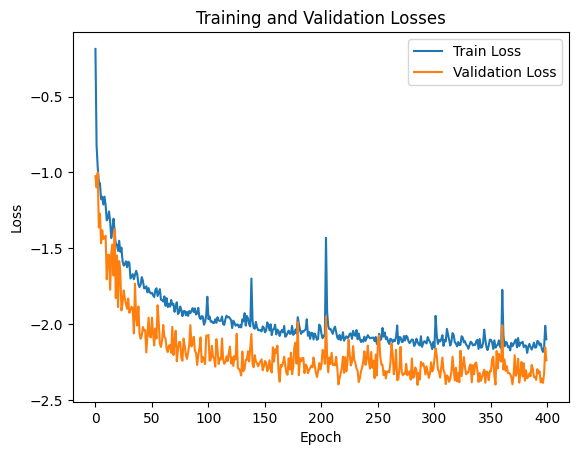

In [297]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [306]:
# model predictions for x_test
model.eval()
predictions = []
sigma2_predictions = []
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        preds = model(x)
        # preds is a tuple (mu, sigma)
        mu_pred, sigma2_pred = preds
        # we only need mu_pred for the predictions
        predictions.append(mu_pred.cpu().numpy())
        sigma2_predictions.append(sigma2_pred.cpu().numpy())
predictions = np.concatenate(predictions, axis=0)
sigma2_predictions = np.concatenate(sigma2_predictions, axis=0)

diffs = predictions - y_test
# rmse
losses = np.sqrt(diffs**2)

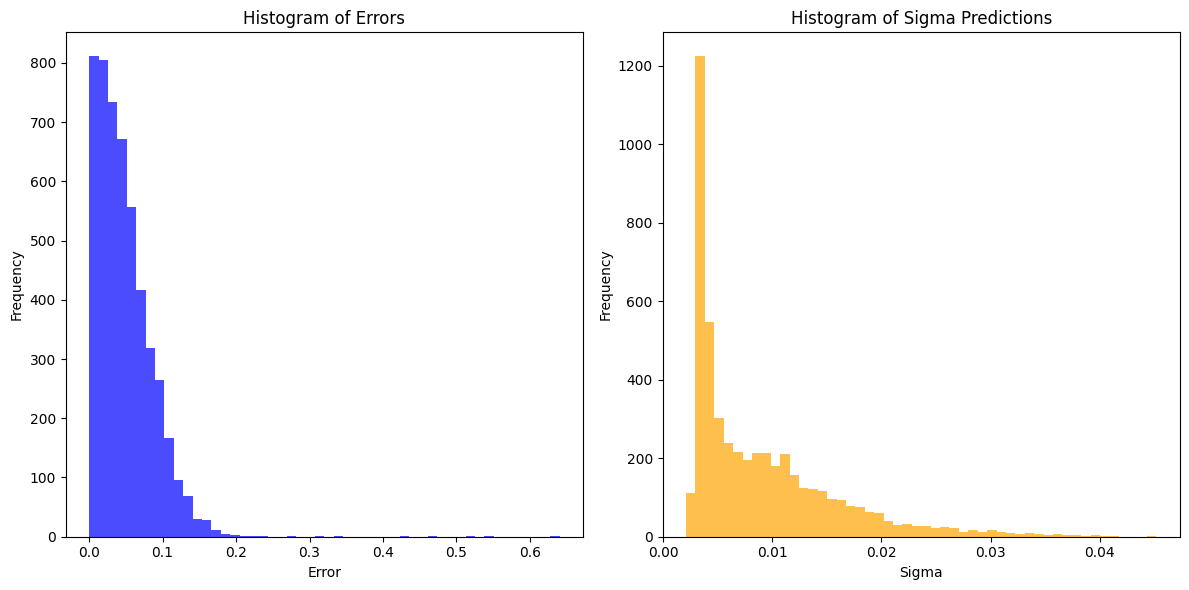

In [299]:
# histogram of errors and sigma predictions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(losses, bins=50, alpha=0.7, color='blue', label='Errors')
axs[0].set_title('Histogram of Errors')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Frequency')
axs[1].hist(sigma2_predictions, bins=50, alpha=0.7, color='orange', label='Sigma Predictions')
axs[1].set_title('Histogram of Sigma Predictions')
axs[1].set_xlabel('Sigma')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

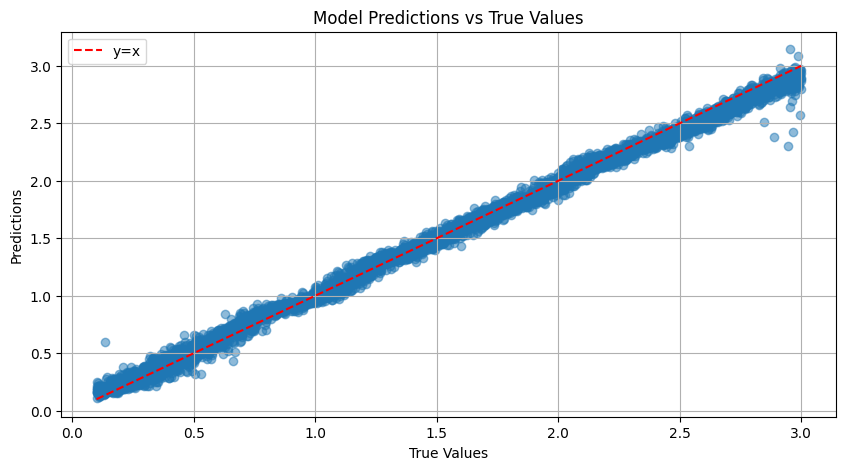

In [300]:
# plot predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Model Predictions vs True Values')
plt.grid()
diagonal_line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(diagonal_line, diagonal_line, color='red', linestyle='--', label='y=x')
plt.legend()
plt.show()


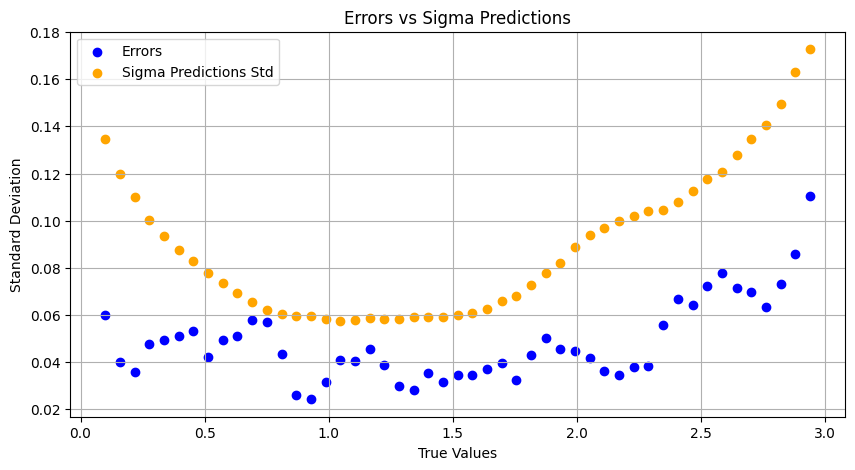

In [301]:
# for the true y values, make bins and get the mean and std of the predictions in each bin
# then compare std of the predictions with the sigma predictions
# binning
bins = np.linspace(min(y_test), max(y_test), 50)
bin_means = []
bin_stds = []
bin_sigmas = []
bin_errors = []
for i in range(len(bins) - 1):
    bin_mask = (y_test >= bins[i]) & (y_test < bins[i + 1])
    if np.any(bin_mask):
        bin_means.append(np.mean(predictions[bin_mask]))
        bin_stds.append(np.std(predictions[bin_mask]))
        bin_errors.append(np.mean(np.abs(predictions[bin_mask] - y_test[bin_mask])))
        bin_sigmas.append(np.mean(np.sqrt(sigma2_predictions[bin_mask])))
    else:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)

bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)
bin_sigmas = np.array(bin_sigmas)

plt.figure(figsize=(10, 5))
plt.scatter(bins[:-1], bin_errors, label='Errors', color='blue')
plt.scatter(bins[:-1], bin_sigmas, label='Sigma Predictions Std', color='orange')
plt.xlabel('True Values')
plt.ylabel('Standard Deviation')
plt.title('Errors vs Sigma Predictions')
plt.grid()
plt.legend()
plt.show()

In [307]:
# Sparsification plot, AUSE
# plot mean absolute error while iteratively removing the data point with the highest predicted uncertainty sigma2

meas = []
predictions_cpy = predictions.copy()
sigma2_predictions_cpy = sigma2_predictions.copy()
y_test_cpy = y_test.copy()
percent_removed = []
for i in range(len(predictions)):
    # Compute mean absolute error
    mae = np.mean(np.abs(predictions_cpy - y_test_cpy))
    meas.append(mae)
    # Remove the data point with the highest predicted uncertainty
    if sigma2_predictions_cpy.size > 0:
        idx = np.argmax(sigma2_predictions_cpy)
        predictions_cpy = np.delete(predictions_cpy, idx)
        y_test_cpy = np.delete(y_test_cpy, idx)
        sigma2_predictions_cpy = np.delete(sigma2_predictions_cpy, idx)

    percent_removed.append((i + 1) / len(predictions) * 100)

meas = np.array(meas)
percent_removed = np.array(percent_removed)

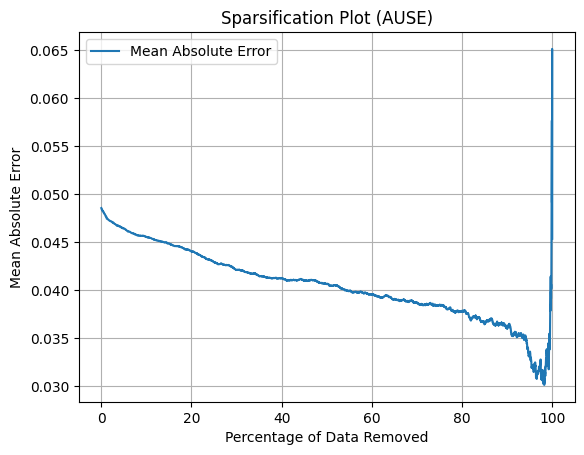

In [309]:
plt.plot(percent_removed, meas, label='Mean Absolute Error')
plt.xlabel('Percentage of Data Removed')
plt.ylabel('Mean Absolute Error')
plt.title('Sparsification Plot (AUSE)')
plt.grid()
plt.legend()
plt.show()

In [311]:
# calculate AUSE
# ToDo